In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
import time

from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from itertools import compress

#### Load Recipes Data

In [2]:
recipes = json.load(open('./data/recipe_train.json'))

# for dic in recipes:
#     ingredients = []
#     for ingredient in dic['ingredients']:
#         tmp_ingredient = ingredient.replace(' ', '-')
#         ingredients.append(tmp_ingredient)
#         dic['ingredients'] = ingredients

#### Convert recipe to text document

In [3]:
recipes_as_doc = {}

for sample in recipes:
    key = sample['cuisine']
    # If key is in the dictionary, return its value. If not, insert key with a value of default and return default.
    recipes_as_doc.setdefault(key,[]).append(' '.join(sample['ingredients']).lower())

# create a single list with all the documents
all_docs = []
for k, v in recipes_as_doc.items():
   all_docs.append(' '.join(v))

#### Tfidf vectorizer for text data

In [4]:
# code adapted from https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf

# vectorizer = TfidfVectorizer(use_idf=True, token_pattern=r"(?u)\b\w[\w-]*\w\b")
vectorizer = TfidfVectorizer(use_idf=True)
transformed_documents = vectorizer.fit_transform(all_docs)

#### Analyze results

In [5]:
transformed_documents_as_array = transformed_documents.toarray()
len(transformed_documents_as_array)
docs_scores_dfs = {}

# loop each item in transformed_documents_as_array, using enumerate to keep track of the current position
for counter, doc in enumerate(transformed_documents_as_array):
    # construct a data frame
    tf_idf_tuples = list(zip(vectorizer.get_feature_names(), doc))
    one_doc_as_df = pd.DataFrame\
        .from_records(tf_idf_tuples, columns=['term', 'score'])\
        .sort_values(by='score', ascending=False)\
        .reset_index(drop=True)
    docs_scores_dfs[list(recipes_as_doc.keys())[counter]] = one_doc_as_df

    print(list(recipes_as_doc.keys())[counter], end=' ')
    # print(one_doc_as_df)
    # output to a csv using the enumerated value for the filename
    # one_doc_as_df.to_csv("tf.idf" + counter.__str__() + ".csv")

greek southern_us filipino indian jamaican spanish italian mexican chinese british thai vietnamese cajun_creole brazilian french japanese irish korean moroccan russian 

#### Statistics of Scores

Text(0, 0.5, 'Number of Therms')

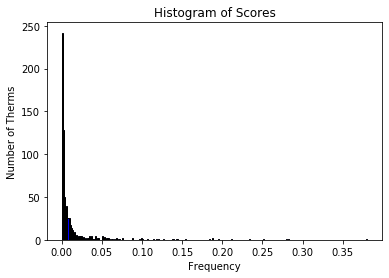

In [6]:
statistics = {}
for k in docs_scores_dfs.keys():
    df = docs_scores_dfs[k]
    scores = df['score']
    scores = scores.loc[scores>0.0]
    statistics[k] = [scores.mean(), scores.max(), scores.min(), df['score'].astype(bool).sum(axis=0)]

irish_scores = docs_scores_dfs["irish"]["score"]
irish_scores = irish_scores.loc[irish_scores>0.0]
plt.hist(irish_scores, color = 'blue', edgecolor = 'black', bins=300)
plt.title('Histogram of Scores')
plt.xlabel('Frequency')
plt.ylabel('Number of Therms')
# print(statistics)

#### Top 10 therms per cuisine

In [7]:
for k in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[k]
    # print('-------------')
    # print(k)
    # print(scores_df.iloc[:15,:])


#### Load Baskets Market Data

In [8]:
baskets = []
with open('./data/groceries.csv', newline=None) as f:
  reader = csv.reader(f)
  for row in reader:
    baskets.append([elem.replace(' ', '-') for elem in row])

#### Compute ngram for tf.idf top score 

In [9]:
top_scores_ngram = {}
CUISINE_TOP_SCORE_THRESHOLD = 0.1
for cuisine in docs_scores_dfs.keys():
    scores_df = docs_scores_dfs[cuisine]
    scores_df = scores_df[scores_df['score']>CUISINE_TOP_SCORE_THRESHOLD]
    scores_df = scores_df.sort_values(by=['score'],ascending=False)
    
    ngram_scores = []
    for index, row in scores_df.iterrows():
        ngram = list(ngrams(row['term'], 3))
        score =  row['score']
        ngram_scores.append([ngram, score, row['term']])
        
    top_scores_ngram[cuisine] = ngram_scores

#### Define the metric similarity

In [10]:
def jaccard_distance(a, b):
    """Calculate the jaccard distance between sets A and B"""
    a = set(a)
    b = set(b)
    return 1.0 * len(a&b)/len(a|b)

#### Compute Basket Scores
For each basket we iterate over all items and compute their similarities with the top 
terms in the cuisines docs.

But first, in order to optimize computation we first calculate ngrams of unique items.

In [11]:
items_ngrams = {}
for basket in baskets:
    for item in basket:
        if items_ngrams.get(item) is None :
            items_ngrams[item] = list(ngrams(item, 3))

In [12]:
start_time = time.time()
baskets_scores = []
all_similarities = {}
for basket in baskets:
    similarities = {}
    for cuisine in top_scores_ngram:
        value = 0
        sims = 0
        for item in basket:      
            item_ngram = items_ngrams[item]
            for ngram_term, score, term in top_scores_ngram[cuisine]:
                if all_similarities.get(item+term) is None:
                    if all_similarities.get(term+item) is None:
                        sim = jaccard_distance(item_ngram, ngram_term)
                        all_similarities[item+term] = sim
                        all_similarities[term+item] = sim
                    else:
                        sim = all_similarities[term+item]
                else:
                    sim = all_similarities[item+term]

                if sim > 0.2:
                    value += sim * score
                    sims += sim
        if sims != 0:
            value = value/sims
        else:
            value=0
                    
        similarities[cuisine] = value    
    baskets_scores.append(similarities)
           
    # print('------------------')
    # print("basket: ", basket)
    # for k in similarities:
    #     print(k, similarities[k]) 
baskets_scores_df = pd.DataFrame(baskets_scores)
baskets_scores_df=(baskets_scores_df-baskets_scores_df.mean())/baskets_scores_df.std()
print("--- %s seconds ---" % (time.time() - start_time))

--- 10.044097423553467 seconds ---


#### CLustering baskets
We now try to cluster the baskets, based on the scores that they 
obtained using frequent therms of recipes

In [13]:
X = StandardScaler().fit_transform(baskets_scores_df.to_numpy())

In [14]:
# OPTICS
optics = OPTICS(min_samples=50, max_eps=0.1, xi=.05, min_cluster_size=.05)
optics.fit(X)
optics_labels = optics.labels_[optics.ordering_]
print(set(optics_labels))

{0, 1, 2, -1}


/home/nepotu/anaconda3/envs/dataMiningProject/lib/python3.7/site-packages/sklearn/cluster/_optics.py:802: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [15]:
# K-Means
kMeans = KMeans(n_clusters=7, random_state=0).fit(X)
kMeans_labels = kMeans.labels_
print(set(kMeans_labels))

{0, 1, 2, 3, 4, 5, 6}


In [27]:
# DBSCAN 
[eps, min_samples] = [0.35, 200]
dbScan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean').fit(X)
dbScan_labels = dbScan.labels_
print(set(dbScan_labels))
print([eps, min_samples])


{0, 1, 2, 3, 4, -1}
[0.05, 200]


#### Analysis of the method
Observe size of created basket clusters

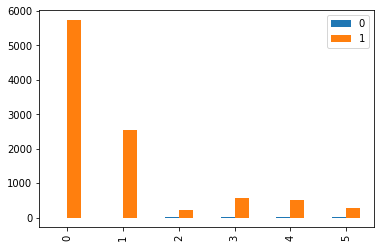

In [28]:
labels = dbScan_labels
cluster_sizes = []
for label in sorted(set(labels)):
    cluster_sizes.append([label, len(baskets_scores_df[labels == label])])
pd.DataFrame(cluster_sizes).plot(kind='bar')

Select one cluster and calculate its overall score (by summing
all scores of all items of that cluster)

In [29]:
for selected_basket_cluster in set(labels):
    print("Cluster ", selected_basket_cluster)
    selected_basket_scores = baskets_scores_df[labels == selected_basket_cluster]
    print("#Baskets: ", selected_basket_scores.shape[0])
    aggregated_basket_cluster_score \
        = np.mean(selected_basket_scores, axis=0)\
        .sort_values(ascending=False)
    selected_baskets = list(compress(baskets, labels == selected_basket_cluster))
    selected_baskets = [' '.join(l) for l in selected_baskets]
    aggregated_basket_cluster_score = aggregated_basket_cluster_score[0:50]
    print(aggregated_basket_cluster_score)

Cluster  0
#Baskets:  2544
moroccan       -0.390361
spanish        -0.428859
italian        -0.505883
korean         -0.505908
japanese       -0.532724
chinese        -0.551486
indian         -0.568075
vietnamese     -0.576202
greek          -0.603279
mexican        -0.603313
cajun_creole   -0.609345
french         -0.773731
jamaican       -0.838674
brazilian      -0.840716
filipino       -0.860176
russian        -0.861334
thai           -0.907920
british        -0.914826
southern_us    -0.915637
irish          -0.994313
dtype: float64
Cluster  1
#Baskets:  212
greek           0.604127
moroccan       -0.390361
spanish        -0.428859
italian        -0.505883
korean         -0.505908
japanese       -0.532724
chinese        -0.551486
indian         -0.568075
vietnamese     -0.576202
mexican        -0.603313
cajun_creole   -0.609345
french         -0.773731
jamaican       -0.838674
brazilian      -0.840716
filipino       -0.860176
russian        -0.861334
thai           -0.907920
british

#### Baseline method - K-means
Now we will implement the baseline algorithm to compare our method with. 
A KNN method will be used. We will try to find the best K by trial and error based on the
coherence of the results because there are not many possible Ks for the given dataset.

In [19]:
baskets_as_docs = [' '.join(basket) for basket in baskets]
X_Baskets = vectorizer.fit_transform(baskets_as_docs)
model = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=1)
model.fit(X_Baskets)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
baseline_labels = set(model.labels_)
for i in baseline_labels:
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 hygiene
 articles
 vegetables
 fruit
 milk
 whole
 napkins
 other
 bags
 bottled
Cluster 1:
 vegetables
 milk
 whole
 other
 cream
 yogurt
 frozen
 newspapers
 root
 cheese
Cluster 2:
 canned
 beer
 soda
 buns
 rolls
 newspapers
 vegetables
 milk
 fruit
 wine
Cluster 3:
 bottled
 water
 beer
 soda
 milk
 whole
 vegetables
 wine
 liquor
 fruit
Cluster 4:
 specialty
 chocolate
 bar
 soda
 vegetables
 marshmallow
 rolls
 buns
 milk
 cheese
Cluster 5:
 shopping
 bags
 vegetables
 soda
 milk
 canned
 sausage
 beer
 buns
 rolls
Cluster 6:
 soda
 pastry
 sausage
 milk
 chocolate
 beverages
 waffles
 frankfurter
 coffee
 whole
Cluster 7:
 buns
 rolls
 milk
 soda
 sausage
 whole
 vegetables
 bottled
 yogurt
 fruit
Cluster 8:
 fruit
 tropical
 vegetables
 pip
 citrus
 juice
 vegetable
 milk
 whole
 other
Cluster 9:
 bread
 brown
 white
 vegetables
 milk
 whole
 fruit
 semi
 finished
 other


#### Compute Scores of Baskets created using K-Means
For the created clusters of baskets using the baseline method, 
we calculate its scores in terms of similarity with the terms
that scored high TF-IDF for the cuisines 

In [20]:
baseline_baskets_scores = {}
for cluster in baseline_labels:
    basket_scores = baskets_scores_df[model.labels_ == cluster]
    cluster_scores = np.mean(basket_scores,axis=0).sort_values()
    np.argsort(cluster_scores)
    print(cluster_scores)

italian         0.186383
mexican         0.190261
cajun_creole    0.230859
moroccan        0.243217
greek           0.253509
spanish         0.261457
indian          0.280015
irish           0.280503
jamaican        0.296406
vietnamese      0.304387
british         0.306389
french          0.307074
russian         0.311748
southern_us     0.318269
japanese        0.326204
brazilian       0.330248
chinese         0.337361
filipino        0.344067
korean          0.359255
thai            0.400019
dtype: float64
japanese       -0.070368
chinese        -0.041024
vietnamese     -0.029170
korean         -0.027026
french         -0.022642
filipino       -0.018381
indian          0.005493
jamaican        0.006427
russian         0.016297
irish           0.018287
italian         0.036310
spanish         0.051779
greek           0.056253
brazilian       0.059465
southern_us     0.063626
british         0.072453
cajun_creole    0.072707
mexican         0.079644
moroccan        0.086311
thai      